In [1]:
"""
Grid preparation for future aspen:
    - Future aspen suitability
    - Future fire probability
    - Future population density projections
    
Author: maxwell.cook@colorado.edu
"""

import os, sys, time
import pandas as pd
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from sklearn.preprocessing import MinMaxScaler

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/')

# Custom functions
sys.path.append(os.path.join(maindir,'aspen-fire/Aim2/code/Python'))
from __functions import *

proj = 'EPSG:5070' # albers

print("Ready to go !")

Ready to go !


In [2]:
# load the future fire probability (vector)
fp = os.path.join(projdir,'Aim3/data/spatial/mod/fire/CNRM_Ens_2060.gpkg')
fire = gpd.read_file(fp)
fire.columns

Index(['values', 'grid_id', 'US_L4NAME', 'US_L4CODE', 'US_L3CODE', 'US_L3NAME',
       'NA_L3CODE', 'NA_L3NAME', 'NA_L2CODE', 'NA_L2NAME', 'NA_L1CODE',
       'NA_L1NAME', 'L4_KEY', 'L3_KEY', 'L2_KEY', 'L1_KEY', 'Shape_Leng',
       'Shape_Area', 'Year', 'En_Area', 'En_NFire', 'geometry'],
      dtype='object')

In [3]:
fire.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
fire['NA_L3NAME'].unique()

array(['Southern Rockies', 'Colorado Plateaus', 'Wyoming Basin',
       'Northwestern Great Plains', 'High Plains',
       'Southwestern Tablelands', 'Arizona/New Mexico Plateau'],
      dtype=object)

In [5]:
fire = fire[fire['NA_L3NAME'] == 'Southern Rockies']
fire = fire[['grid_id','values','Year','En_Area','En_NFire','geometry']]
fire.head()

,grid_id,values,Year,En_Area,En_NFire,geometry
0,308742,0.0,2060,18305.391284,1.643757,"MULTIPOLYGON (((-1180296.427 1745752.683, -117..."
1,308742,0.0,2060,3842.041755,0.397480,"MULTIPOLYGON (((-1180296.427 1745752.683, -117..."
3,308743,0.0,2060,18305.391284,1.643757,"MULTIPOLYGON (((-1176851.975 1745256.614, -117..."
4,308743,0.0,2060,3842.041755,0.397480,"MULTIPOLYGON (((-1176851.975 1745256.614, -117..."
6,308744,0.0,2060,18305.391284,1.643757,"MULTIPOLYGON (((-1173407.314 1744761.996, -116..."


In [6]:
# check for duplicates, remove them
n = fire.duplicated(subset=['grid_id','Year']).sum()
if n > 0:
    print(f"\nDropping [{n}] duplicate rows.\n")
    fire = fire.drop_duplicates(subset=['grid_id','Year'])
else:
    print("\nNo duplicates at this stage.\n")


Dropping [7227] duplicate rows.



In [7]:
print(f"\nThere are {len(fire)} future fire grids in the Southern Rockies.\n")


There are 10319 future fire grids in the Southern Rockies.



## Calculate aspen suitability metrics

In [8]:
# load the future aspen suitability
fp = os.path.join(projdir,'Aim3/data/spatial/raw/aspen_suitability/Predictions/predicted_SSP245_2041-2070_ensemble.tif')
aspen = rxr.open_rasterio(fp, cache=False).squeeze()
print(f"\n{aspen}\n")


<xarray.DataArray (y: 9317, x: 5715)> Size: 213MB
[53246655 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 46kB 9.022e+04 9.03e+04 ... 6.044e+05 6.045e+05
  * y            (y) float64 75kB 4.74e+06 4.74e+06 ... 3.902e+06 3.902e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  0.72700226306915
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  0.012364179827273
    STATISTICS_STDDEV:   -9999
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           suitability



In [9]:
aspen.rio.crs

CRS.from_epsg(32613)

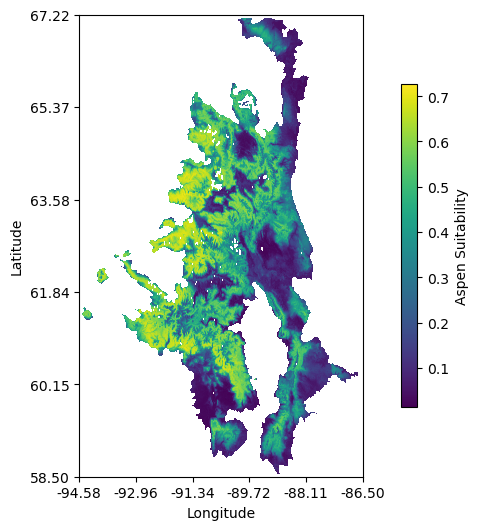

In [10]:
plot_raster(aspen, legend_lab = "Aspen Suitability")

In [11]:
# calculate band statistics
# mean, standard deviation, percentiles

# reproject the aspen grid
aspen = aspen.rio.reproject(proj)

# calculate zonal statistics
future_aspen = compute_band_stats(
    geoms=fire, 
    image_da=aspen, 
    id_col='grid_id', 
    stats=['mean','median','std','percentile_90'],
    attr='f_aspen',
    ztype='continuous'
)

future_aspen.head()

,grid_id,f_aspen_mean,f_aspen_median,f_aspen_std,f_aspen_percentile_90
0,308742,0.201919,0.181004,0.088760,0.314396
1,308743,0.270885,0.256800,0.131591,0.462974
2,308744,0.130891,0.118386,0.045075,0.183206
3,309922,0.261737,0.225483,0.144787,0.475948
4,309923,0.436195,0.444325,0.081355,0.531896


In [12]:
# rename the columns
future_aspen = future_aspen.rename(
    columns={
        'f_aspen_percentile_90': 'f_aspen_p90',
        'f_aspen_mean': 'f_aspen_mn',
        'f_aspen_median': 'f_aspen_med'
    }
)

# join to the fire dataframe
fire_fa = pd.merge(fire, future_aspen, on="grid_id", how="left")
fire_fa.head()

,grid_id,values,Year,En_Area,En_NFire,geometry,f_aspen_mn,f_aspen_med,f_aspen_std,f_aspen_p90
0,308742,0.0,2060,18305.391284,1.643757,"MULTIPOLYGON (((-1180296.427 1745752.683, -117...",0.201919,0.181004,0.088760,0.314396
1,308743,0.0,2060,18305.391284,1.643757,"MULTIPOLYGON (((-1176851.975 1745256.614, -117...",0.270885,0.256800,0.131591,0.462974
2,308744,0.0,2060,18305.391284,1.643757,"MULTIPOLYGON (((-1173407.314 1744761.996, -116...",0.130891,0.118386,0.045075,0.183206
3,309922,0.0,2060,18305.391284,1.643757,"MULTIPOLYGON (((-1180936.447 1741315.321, -117...",0.261737,0.225483,0.144787,0.475948
4,309923,0.0,2060,18305.391284,1.643757,"MULTIPOLYGON (((-1177490.127 1740818.984, -117...",0.436195,0.444325,0.081355,0.531896


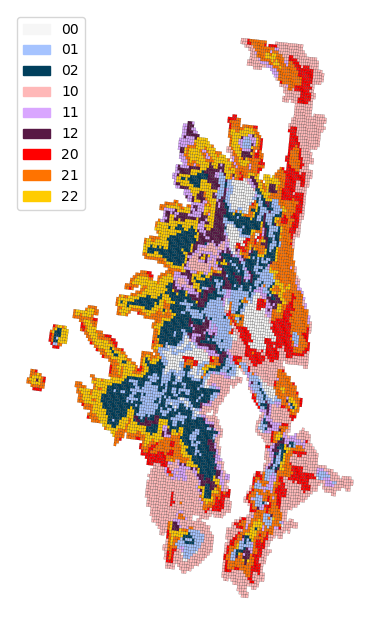

In [13]:
# Create a bivariate map of future fire/future aspen
scaler = MinMaxScaler()
fire_fa[["En_NFire_sc", "f_aspen_mn_sc"]] = scaler.fit_transform(fire_fa[["En_NFire", "f_aspen_mn"]])

# Define class breaks (e.g., tertiles or quartiles)
fire_fa["fire_class"] = np.digitize(
    fire_fa["En_NFire_sc"], 
    np.quantile(fire_fa["En_NFire_sc"], [0.33, 0.67]))
fire_fa["aspen_class"] = np.digitize(
    fire_fa["f_aspen_mn_sc"], 
    np.quantile(fire_fa["f_aspen_mn_sc"], [0.33, 0.67]))

# Combine classifications to create bivariate classes
fire_fa["bivar"] = fire_fa["fire_class"].astype(str) + fire_fa["aspen_class"].astype(str)

# Define a custom bivariate colormap
bivar_colors = {
    "00": "#f6f6f6",  # Low fire, low aspen
    "01": "#a5c3ff",  # Low fire, medium aspen
    "02": "#003f5c",  # Low fire, high aspen
    "10": "#ffb8b8",  # Medium fire, low aspen
    "11": "#d9a6ff",  # Medium fire, medium aspen
    "12": "#581845",  # Medium fire, high aspen
    "20": "#ff0000",  # High fire, low aspen
    "21": "#ff7300",  # High fire, medium aspen
    "22": "#ffcc00",  # High fire, high aspen
}

# Assign colors based on the classification
fire_fa["color"] = fire_fa["bivar"].map(bivar_colors)

# Plot the bivariate map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fire_fa.plot(ax=ax, color=fire_fa["color"], edgecolor="black", linewidth=0.1)

legend_patches = [Patch(color=color, label=label) for label, color in bivar_colors.items()]
ax.legend(handles=legend_patches, title="", loc="upper left")
ax.axis("off")

plt.show()

In [14]:
# save this file out
out_fp = os.path.join(projdir, 'Aim3/data/spatial/mod/future_fire_grid.gpkg')
fire_fa.to_file(out_fp)
print(f"Saved to: \n{out_fp}")

Saved to: 
/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim3/data/spatial/mod/future_fire_grid.gpkg


## USFS TreeMap Summaries
### FORTYPCD

In [15]:
# Load the TreeMap (ca. 2016)
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "Aim2/data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the tm_id band
fortyp_da = treemap_da.sel(band=2) # the fortypcd band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = fortyp_da.shape, fortyp_da.spatial_ref.GeoTransform, fortyp_da.rio.crs, fortyp_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {fortyp_da[0].dtype}")

del treemap_da # clean up
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


48

In [16]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(fortyp_da), 1, 0)

# calculate the grid-level forest percent
forest_pct = compute_band_stats(fire, forest_mask, 'grid_id', attr='forest')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
print(forest_pct.head())
# gather the forest percent
forest_pct = forest_pct[forest_pct['forest'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_id','forest_pixels','forest_pct']]
# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(fire)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

del forest_mask
gc.collect() # clean up

   grid_id  forest  count  forest_pixels  forest_pct
0   308742       0   5042          17642   28.579526
1   308742       1  12600          17642   71.420474
2   308743       0   3317          17637   18.807053
3   308743       1  14320          17637   81.192947
4   308744       0   4562          17649   25.848490

[65.24%] predominantly forest grids.

   grid_id  forest_pixels  forest_pct
1   308742          17642   71.420474
3   308743          17637   81.192947
5   308744          17649   74.151510


15

In [17]:
# also calculate the FORTYPCD
t0 = time.time()

# see __functions.py
fire_fa_fortyp = compute_band_stats(fire_fa, fortyp_da, 'grid_id', attr='fortypcd')

# tidy columns in the summary table
fire_fa_fortyp['count'] = fire_fa_fortyp['count'].astype(int)
fire_fa_fortyp['total_pixels'] = fire_fa_fortyp['total_pixels'].astype(int)
fire_fa_fortyp.rename(columns = {'count': 'fortyp_pixels'}, inplace=True)

# load the species lookup table
fp = os.path.join(projdir,'Aim2/data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df.rename(columns={
    'FORTYPCD': 'fortypcd',
    'SpeciesName': 'fortypnm'
}, inplace=True)

# join the forest name
fire_fa_fortyp = fire_fa_fortyp.merge(species_df, on='fortypcd', how='left')
print(f"\n{fire_fa_fortyp.head(3)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del fortyp_da, species_df # clean up 
gc.collect()


   grid_id  fortypcd  fortyp_pixels  total_pixels  pct_cover  \
0   308742       171              7         12600   0.055556   
1   308742       182             14         12600   0.111111   
2   308742       184           3376         12600  26.793651   

                 fortypnm  
0        Eastern redcedar  
1  Rocky Mountain juniper  
2        Juniper woodland  

Total elapsed time: 0.26 minutes.

~~~~~~~~~~



15

In [ ]:
fire_fa_fortyp['fortypnm'].unique()

In [ ]:
# subset to southern rockies forest types
fortyp_srm = [
    'Rocky Mountain juniper', 'Pinyon / juniper woodland', 'Douglas-fir', 'Ponderosa pine',
    'White fir', 'Engelmann spruce', 'Cottonwood', 'Aspen', 'Deciduous oak woodland',
    'Nonstocked', 'Lodgepole pine', 'Willow', 'Cercocarpus (mountain brush) woodland',
    'Engelmann spruce / subalpine fir', 'Subalpine fir', 'Foxtail pine / bristlecone pine', 
    'Limber pine', 'Cottonwood / willow', 'Blue spruce', 'Evergreen oak woodland', 
    'Mixed upland hardwoods'
]

# subset the dataframe
fire_fa_fortyp = fire_fa_fortyp[fire_fa_fortyp['fortypnm'].isin(fortyp_srm)]

# Aggregate into forest groups
spp_grouping = {
    'pinyon / juniper woodland|rocky mountain juniper': 'Piñon-juniper',
    'engelmann spruce|subalpine fir|blue spruce': 'Spruce-fir',
    'ponderosa pine': 'Ponderosa', 
    'lodgepole pine': 'Lodgepole', 
    'aspen': 'Quaking aspen',
    'douglas-fir|white fir': 'Mixed-conifer',
    'deciduous oak woodland|cercocarpus': 'Oak-woodland',
    'cottonwood|willow|cottonwood / willow': 'Riparian'
}

# create the remap table
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = fire_fa_fortyp[fire_fa_fortyp['fortypnm'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update(
        {name: spp_group for name in spp['fortypnm'].unique()}
    )
    del spp
    
# Apply the remap to create a new grouped species column
fire_fa_fortyp['fortypnm_gp'] = fire_fa_fortyp['fortypnm'].map(spp_remap).fillna(fire_fa_fortyp['fortypnm'])
# Verify the updated species groups
print(fire_fa_fortyp[['fortypnm', 'fortypnm_gp']].drop_duplicates().head(3))
print(f"\n{fire_fa_fortyp.columns}")

In [ ]:
# Aggregate with the new species groupings
# Reacalculate the percent cover for each species group
fire_fa_fortypgp = (
    fire_fa_fortyp.groupby(['grid_id','fortypnm_gp'], as_index=False)
    .agg(
        fortyp_pixels=('fortyp_pixels','sum'),
        total_pixels=('total_pixels','max'),
        fortyp_pct=('pct_cover','sum'),
    )
)

# Merge in the forest percent
fire_fa_fortypgp = fire_fa_fortypgp.merge(forest_pct, on='grid_id', how='inner')

# Check on nulls introduced
print(f"\nNaNs in FORTYP group name: {fire_fa_fortypgp['fortypnm_gp'].isna().sum()}\n")
print(f"\n{fire_fa_fortypgp.head(10)}\n")
print(f"Forest percent:\n{fire_fa_fortypgp['forest_pct'].describe()}\n")
print("\n~~~~~~~~~~~~~~~~~~\n")

gc.collect()

In [ ]:
# Create a histogram of the forest species (prevalence)
fortyp = fire_fa_fortypgp.copy() # make a copy to work with
fortyp = fortyp[fortyp['fortyp_pixels'] > 0] # make sure there are some pixels

# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('fortypnm_gp')['fortyp_pixels'].sum().reset_index()
spp_pr['fraction'] = spp_pr['fortyp_pixels'] / spp_pr['fortyp_pixels'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.99]
print(f"\n\nSpecies making up 99% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='fortypnm_gp', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# clean up
del fortyp, spp_pr
gc.collect()

In [ ]:
# Get the species co-occurrence percentages
spps = fire_fa_fortypgp['fortypnm_gp'].unique()
coo = get_spp_coo(fire_fa_fortypgp, spps, grid_col='grid_id') # see '__functions.py')
print(f"\n{coo.head(30)}\n")

In [ ]:
# merge to the fire data again
fire_fa_tm = pd.merge(fire_fa, fire_fa_fortypgp, on='grid_id', how='left')
fire_fa_tm.columns

In [ ]:
print(len(fire_fa_tm))
print(len(fire_fa_tm['grid_id'].unique()))

In [ ]:
fire_fa_tm['fortypnm_gp'].unique()

In [ ]:
# check how many grids have aspen/lodgepole FORTYPCD
lodgepole_grids = fire_fa_tm[fire_fa_tm['fortypnm_gp'] == 'Lodgepole']['grid_id'].unique()
aspen_grids = fire_fa_tm[fire_fa_tm['fortypnm_gp'] == 'Quaking aspen']['grid_id'].unique()
# find common grids
common_grids = set(lodgepole_grids) & set(aspen_grids)
df_cooccur = fire_fa_tm[fire_fa_tm['grid_id'].isin(common_grids)]
print(f"\n[{len(df_cooccur['grid_id'].unique())}] future fire grids with any aspen & lodgepole.")

## Sentinel-based contemporary aspen cover

In [ ]:
# load the Sentinel-based aspen data
